# Step 0: Installing requirements

The [conda](https://docs.conda.io/en/latest/) package manager is used to install the packages used in this workflow. If GROMACS is not already installed on your machine, it can be obtained by running `conda install -c bioconda gromacs`
## Also need ILForcefields but that's private

In [1]:
!conda install --file requirements.txt --yes

Solving environment: done

# All requested packages already installed.



## Step 1: Using the KPL force field

The Köddermann-Paschek-Ludwig Forcefield is a forcefield commonly used to atom type Ionic Liquids. More information can be found at these references:

Modeling Ionic Liquids Using a Systematic All-Atom Force Field
José N. Canongia Lopes, Johnny Deschamps, and Agílio A. H. Pádua
The Journal of Physical Chemistry B 2004 108 (6), 2038-2047
DOI: 10.1021/jp0362133

Köddermann T, Paschek D, Ludwig R. Molecular dynamic simulations of ionic liquids: a reliable description of structure, thermodynamics and dynamics. Chemphyschem. 2007;8(17):2464-2470. doi:10.1002/cphc.200700552

A small portion of KPL has been implemented in files provided in this workflow.

## Step 2: Building the mBuild compound
We are able to load in the molecules through .mol2 files which we can create using software such as Avogadro

In [22]:
import mbuild as mb

tf2n = mb.load('tfsi.mol2')
emim = mb.load('emim.mol2')

emim.name = 'emim'
tf2n.name = 'tf2n'

We are then able to [mb.fill_box](https://mosdef.org/mbuild/recipes.html?highlight=fill_box#mbuild.packing.fill_box) to specify size of box, number of atoms, density and so on.

In [23]:
system = mb.fill_box(compound=[tf2n, emim],
        n_compounds=[50,50], density=1530)

## Step 3: Applying the Foyer force field
The KPL XML provided can be found on https://github.com/mattwthompson/ilforcefields.git
We can apply the Forcefield to the system we generated in the previous cell.

In [24]:
from foyer import Forcefield

FF = Forcefield('kpl.xml')

tf2nP = mb.Compound()
emimP = mb.Compound()

Due to having to sometimes use different Forcefields for different compounds and Foyer currently not supporting assigning different FF parameters to different compounds we must use a for loop to separate the system out into individual compounds and then apply the forcefields separately. 

But in this case the same Forcefield is being used, so technically we don't have to do the for loop but it's useful to see.

In [25]:
for child in system.children:
    if child.name == 'emim':
        emimP.add(mb.clone(child))
    else:
        tf2nP.add(mb.clone(child))

tf2nPM = FF.apply(tf2nP, residues=['tf2n'])  #apply forcefield to IL's
emimPM = FF.apply(emimP, residues=['emim'] )

systemPM = tf2nPM + emimPM

Then we can save the system as .top and .gro files which store the initial state of the system

In [26]:
systemPM.save('init.top', overwrite=True)
systemPM.save('init.gro', overwrite=True)

## Step 4: Running the simulation

As with most simulation engines, an input or control file is necessary. 
For gromacs, this is the MDP file. There are 4 MDP stored in this folder, they each do a different job. The fill box function just puts all the molecules in a box without much thought to it's positioning, that's why we first run the Energy Minization (em) step.

In [27]:
import subprocess

grompp_cmd = 'gmx grompp -f em.mdp -c init.gro -p init.top -o em.tpr'
p = subprocess.Popen(grompp_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('em.out', 'w') as f:
    f.write(out)
with open('em.err', 'w') as f:
    f.write(err)

This creates a .tpr file, which can then be run.

In [28]:
mdrun_cmd = 'gmx mdrun -deffnm em'
p = subprocess.Popen(mdrun_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('nvt.out', 'w') as f:
    f.write(out)
with open('nvt.err', 'w') as f:
    f.write(err)

Next we run a nvt ensemble, this stabilises the Temperature we want to run the Simulation at.

In [29]:
grompp_cmd = 'gmx grompp -f nvt.mdp -c em.gro -p init.top -o nvt.tpr'
p = subprocess.Popen(grompp_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('nvt.out', 'w') as f:
    f.write(out)
with open('nvt.err', 'w') as f:
    f.write(err)

In [30]:
mdrun_cmd = 'gmx mdrun -deffnm nvt'
p = subprocess.Popen(mdrun_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('nvt.out', 'w') as f:
    f.write(out)
with open('nvt.err', 'w') as f:
    f.write(err)

Next we have to run an NPT ensemble, to stabilise the system to a Pressure which we want it to run at. But we are not going to go through how to run an NPT as it takes too long. After the NPT is complete, we can run our sample simulation to get results on Diffusivity, Density and other things.

## Step 5: Analysis

Without running enough simulations to fully equilibrate and sample a system, we can simply do a check on the energy of the system as a function of time. We use the `panedr` package to parse the EDR file, which is a binary format, to a `pandas` dataframe.

In [31]:
import panedr

df = panedr.edr_to_df('nvt.edr')

energies = ['Potential', 'LJ (SR)', 'Angle', 'Coulombic']

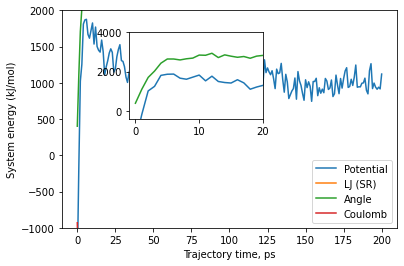

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition


fig, ax = plt.subplots()

axins = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.2,0.5,0.4,0.4])
axins.set_axes_locator(ip)

for energy in energies:
    if energy == 'Coulombic':
        ax.plot(df['Time'], df['Coulomb (SR)'] + df['Coul. recip.'], label='Coulomb')
        axins.plot(df['Time'], df['Coulomb (SR)'] + df['Coul. recip.'], label='Coulomb')
        continue
    else:
        ax.plot(df['Time'], df[energy], label=energy)
        axins.plot(df['Time'], df[energy], label=energy)

    ax.set_xlabel('Trajectory time, ps')
    ax.set_ylabel('System energy (kJ/mol)')

ax.set_ylim((-1000, 2000))
axins.set_xlim((-1, 20))
axins.set_ylim((-400, 4000))
ax.legend()

Gromacs also has it's own inbuilt function which allows us to analyse information from the simulation

In [33]:
energy_cmd = 'gmx energy -f nvt.edr -o results.xvg'
p = subprocess.Popen(energy_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)